# Model Comparison With Finance Data
This notebook demonstrates how to run the prediction models on financial data

In [1]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
from src.models.DL_LSTM import build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [3]:
# load parquet data to pandas dataframe
retail_train= pd.read_parquet('../data/dataset_retail/processed/train_featured_s1_i1.parquet')
retail_validation= pd.read_parquet('../data/dataset_retail/processed/validation_featured_s1_i1.parquet')

# Combine both DataFrames
combined_data = pd.concat([retail_train, retail_validation], ignore_index=True)

target = 'sales'

combined_data


,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,sales_roll_mean_60d,sales_roll_std_60d,sales_roll_median_60d,sales_roll_min_60d,sales_roll_max_60d,sales_roll_mean_90d,sales_roll_std_90d,sales_roll_median_90d,sales_roll_min_90d,sales_roll_max_90d
0,2014-01-01,9,2014,1,1,2,1,1,1,1,...,15.416667,5.645732,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
1,2014-01-02,14,2014,1,2,3,2,1,1,0,...,15.333333,5.628820,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
2,2014-01-03,11,2014,1,3,4,3,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
3,2014-01-04,20,2014,1,4,5,4,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
4,2014-01-05,17,2014,1,5,6,5,1,1,0,...,15.333333,5.643856,16.0,5.0,31.0,15.744444,5.135383,16.0,5.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-12-27,14,2017,12,27,2,361,52,4,0,...,19.866667,6.261171,19.0,6.0,34.0,20.388889,5.988180,20.0,6.0,34.0
1457,2017-12-28,19,2017,12,28,3,362,52,4,0,...,19.700000,6.145965,19.0,6.0,34.0,20.288889,5.934558,20.0,6.0,34.0
1458,2017-12-29,15,2017,12,29,4,363,52,4,0,...,19.583333,6.167964,19.0,6.0,34.0,20.122222,5.869035,20.0,6.0,34.0
1459,2017-12-30,27,2017,12,30,5,364,52,4,0,...,19.633333,6.216344,19.0,6.0,34.0,20.188889,5.913030,20.0,6.0,34.0


In [5]:
combined_data = pd.read_csv('../data/dataset_energy/combined_df_with_features.csv.gz')
target = 'Energy_Demand'

combined_data

,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure,hour,dayofweek,month,lag_1,lag_12,lag_288,lag_576,rolling_mean_24,rolling_std_24
0,7294.03,4.370966,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,7304.76,4.507557,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.371,NaN,NaN,NaN,NaN,NaN
2,7176.53,4.476996,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.508,NaN,NaN,NaN,NaN,NaN
3,7247.72,4.497028,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.477,NaN,NaN,NaN,NaN,NaN
4,7169.96,4.478132,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.497,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296679,7467.70,4.900523,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.894,4.730,4.901,4.687,4.736,0.094
296680,7393.27,4.967171,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.901,4.715,4.817,4.478,4.746,0.098
296681,7360.53,4.888091,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.967,4.722,4.730,4.591,4.759,0.106
296682,7345.74,4.894027,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.888,4.703,4.714,4.483,4.768,0.107


In [ ]:
# ARIMA is represented by three parameters: p, d, and q:
# p: The number of past values (lags) considered in the AR term.
# d: The degree of differencing applied to the data.
# q: The number of past forecast errors included in the MA term.
# order = (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.

order = (5, 1, 0)
predictions, train, test = build_arima_model(combined_data['Close_TSLA'], order, 0.7)

# Convert to numpy arrays (in case they're lists)
test = np.array(test)
predictions = np.array(predictions)
 
rmse, mse, mae, mape, r2, adj_r2	= generate_model_metrics(predictions, test)

# Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Mean Squared Error
# mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)

# Mean Absolute Error
# mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)

# Mean Absolute Percentage Error
# mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Test MAPE: %.3f' % mape)

# R-squared
# r2 = r2_score(test, predictions)
print('Test R²: %.3f' % r2)

# Adjusted R-squared
n = len(test)
p = 1  # number of predictors (just 1 for ARIMA by default)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('Adjusted R²: %.3f' % adj_r2)

# plot forecasts against actual outcomes
plt.plot(test, color='blue', label='Actual', linewidth=2, alpha=0.7)
plt.plot(predictions, color='red', label='Predicted', linestyle='--', linewidth=2)
plt.legend()
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
metrics_scores = {}
metrics_scores[target_ticker] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "MAPE": mape, "R2": r2, "Adj_R2": adj_r2}
metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# metrics_df.to_csv("model_metrics_scores.csv")
print(metrics_df)

NameError: name 'rmse' is not defined

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0686 - val_loss: 0.0239
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0151 - val_loss: 0.0159
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0142 - val_loss: 0.0154
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0140 - val_loss: 0.0151
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0129 - val_loss: 0.0146
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0126 - val_loss: 0.0152
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


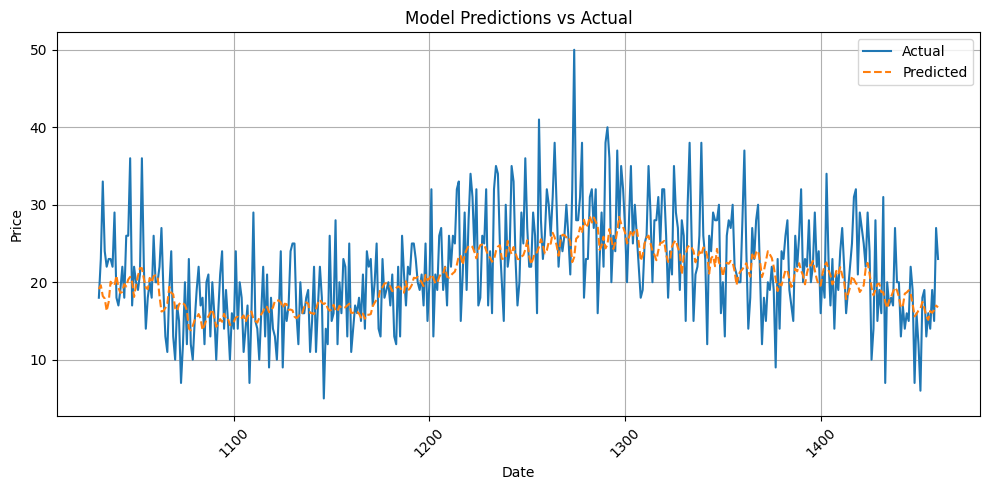

RMSE: 5.673, MAE: 4.395, R²: 0.316


In [29]:
# LSTM Model

# Step 1: Prepare your dataset
X_train, X_test, y_train, y_test, scaler, date_index = prepare_lstm_data(combined_data, target, 30, 0.3)

# Step 2: Build and train the model
n_features = X_train.shape[2]
model = build_lstm_model(30, n_features=n_features)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 3: Predict and evaluate
y_pred = model.predict(X_test)

# Determine the correct number of columns from the scaler
n_total_features = scaler.n_features_in_

# Pad predictions with zeros for inverse transform
y_pred_full = np.zeros((len(y_pred), n_total_features))
y_pred_full[:, -1] = y_pred.flatten()

y_test_full = np.zeros((len(y_test), n_total_features))
y_test_full[:, -1] = y_test.flatten()

# Inverse transform and extract only the target column
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# Step 4: Plot results
plot_predictions(date_index, y_test_inv, y_pred_inv)

# Step 5: Print metrics
rmse, mae, r2 = evaluate_predictions(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")